In [123]:
import sklearn
from packaging import version

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [124]:
# download data
import pandas as pd
import tarfile
import urllib.request
import os 

def load_housing_data() :
    desc_path = "datasets/housing.tgz"
    if not os.path.isfile(desc_path) :
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, desc_path)
        with tarfile.open(desc_path) as f :
            f.extractall(path='datasets')
    return pd.read_csv("datasets/housing/housing.csv")

In [125]:
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [126]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [127]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [128]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


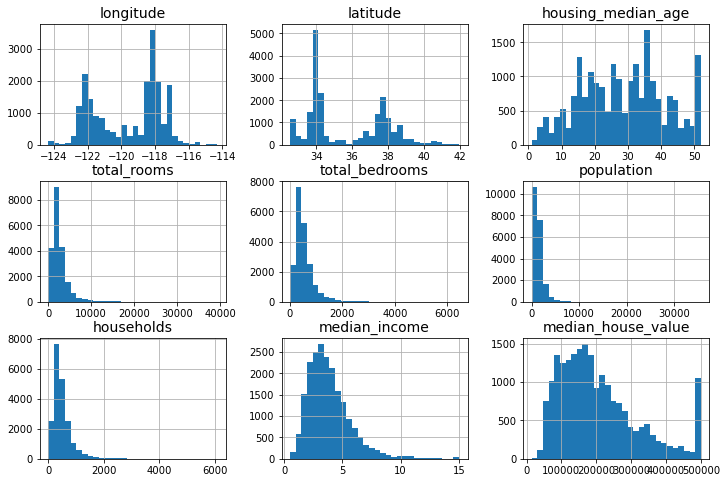

In [129]:
import matplotlib.pyplot as plt
from helper import save_fig

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing_data.hist(bins=30, figsize=(12, 8))
save_fig(name='2_hist_plot')

In [130]:
# create a test set
import numpy as np

def shuffle_and_split_data(data , test_ratio=0.2, seed=0) :
    np.random.seed(seed)
    random_order_idx = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_idx = random_order_idx[:test_size]
    train_idx = random_order_idx[test_size:]
    return data.iloc[train_idx], data.iloc[test_idx]

In [131]:
train_set, test_set = shuffle_and_split_data(data=housing_data)
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [132]:
test_set['total_bedrooms'].isnull().sum()

37

In [133]:
# float to categorical
housing_data['income_cat'] = pd.cut(housing_data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing_data['income_cat'].head()

0    5
1    5
2    5
3    4
4    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

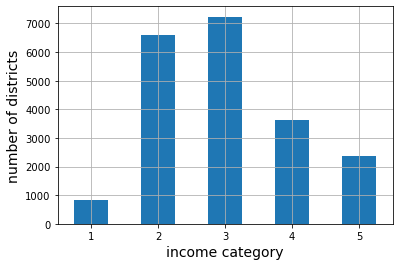

In [134]:
housing_data['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True) # rot=0 -> not rotate xlabel
plt.xlabel('income category')
plt.ylabel('number of districts');

In [135]:
# random multi in split
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=.2, random_state=42)
strat_splits = []
for train_idx, test_idx in splitter.split(housing_data, housing_data['income_cat']) :
    print(train_idx.shape, test_idx.shape)
    strat_train_set_n = housing_data.iloc[train_idx]
    strat_test_set_n = housing_data.iloc[test_idx]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)
(16512,) (4128,)


stratify will balance labels for each set equally.

In [136]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split( 
    housing_data, test_size=0.2, stratify=housing_data['income_cat'], random_state=42
)

# drop labels
for set_ in (train_set, test_set) :
    set_.drop('income_cat', axis=1, inplace=True)

visualization

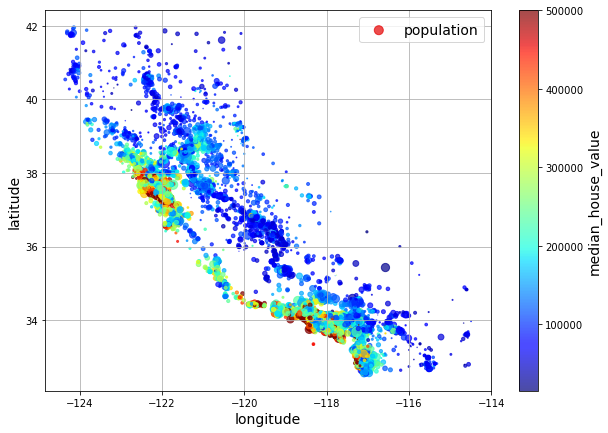

In [137]:
housing = train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, 
             alpha=.7, s=housing['population']/100, label='population',
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
save_fig('california_housing_price_plot')

correlations

In [138]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

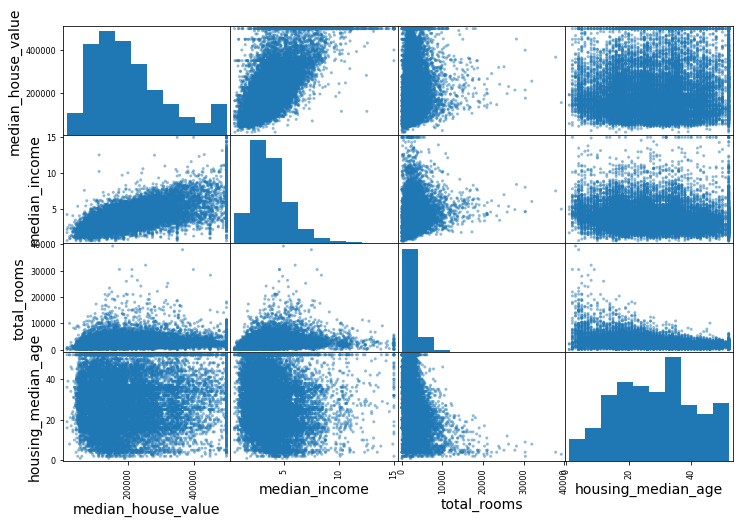

In [139]:
from pandas.plotting import scatter_matrix

attrs = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attrs], figsize=(12, 8));

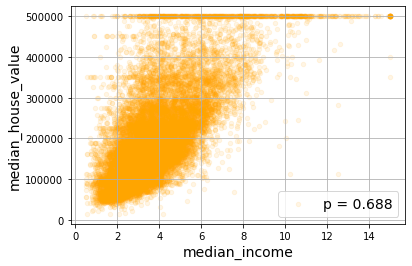

In [140]:
coeff = corr_matrix['median_income']['median_house_value']
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True, c='orange', label=f'p = {coeff:.3f}')
save_fig('coeff_housing')

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" width=400px>

Experiment with Attribute combinations

In [141]:
housing['room_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [142]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
room_per_house        0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Prepare data for ML

In [143]:
label = 'median_house_value'
dataX =  train_set.drop(label, axis=1)
dataY = train_set[label].copy()

In [144]:
# data cleaning
null_row_idx = dataX.isnull().any(axis=1)
dataX.loc[null_row_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [145]:
#option 1 : dropna
opt1 = dataX.copy()
opt1.dropna(subset=['total_bedrooms'], inplace=True)
opt1.loc[null_row_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [146]:
#option 2 : drop the colomn
opt2 = dataX.copy()
opt2.drop('total_bedrooms', axis=1, inplace=True)
opt2.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'ocean_proximity'],
      dtype='object')

In [147]:
# option 3 : fillna with some value
# 3.1 with numerical data
opt3 = dataX.copy()
median = opt3['total_bedrooms'].median()
opt3['total_bedrooms'].fillna(median, inplace=True)
opt3.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
ocean_proximity       False
dtype: bool

In [148]:
# with SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
numerical_data = dataX.select_dtypes(include=[np.number])
imputer.fit(numerical_data)

SimpleImputer(strategy='median')

In [149]:
imputer.statistics_ # median in each columns

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [150]:
dataX.median(numeric_only=True).values # same as above

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [151]:
# convert to np.array
X = imputer.transform(numerical_data)
X.shape, type(X), imputer.feature_names_in_

((16512, 8),
 numpy.ndarray,
 array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'],
       dtype=object))

In [152]:
# drop outliers
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
clf = isolation_forest.fit(X)
outlier_pred = clf.predict(X)

In [153]:
outlier_pred[:10], outlier_pred.shape # outlier = -1

(array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1]), (16512,))

In [154]:
# drop outlier
dataX = dataX.iloc[outlier_pred == 1]
dataY = dataY.iloc[outlier_pred == 1]
dataX.shape, dataY.shape

((14448, 9), (14448,))

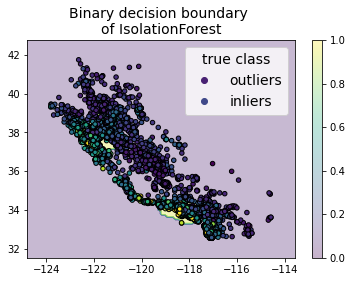

In [155]:
# some visualization with 2D data 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
from sklearn.inspection import DecisionBoundaryDisplay

sampleX = dataX.to_numpy()[:, :2].copy()
clf = isolation_forest.fit(sampleX)
disp = DecisionBoundaryDisplay.from_estimator(clf, sampleX, response_method='predict', alpha=.3)
scatter = plt.scatter(dataX.to_numpy()[:, 0], dataX.to_numpy()[:, 1], c=dataY, s=20, edgecolors='k')
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.colorbar(disp.ax_.collections[1])
save_fig('IsolationForest')

In [156]:
# 3.2 with non-numerical data
cat_data = dataX[['ocean_proximity']] # recive 2D data
cat_data.head()

,ocean_proximity
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND


In [157]:
# one hot and ordinal encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

onehot = OneHotEncoder(sparse_output=False)
cat_data_encoded = onehot.fit_transform(cat_data)
cat_data_encoded[:5], onehot.categories_, onehot.feature_names_in_

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)],
 array(['ocean_proximity'], dtype=object))

Feature Scaling

In [158]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
numerical_data_min_max_scaled = min_max_scaler.fit_transform(numerical_data)
numerical_data_min_max_scaled[:3]

array([[-0.60851927,  0.11702128,  1.        , -0.83117147, -0.64116605,
        -0.80701754, -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, -0.90014752, -0.88629409,
        -0.91866029, -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, -0.94501246, -0.93042358,
        -0.93141946, -0.92458466, -0.73336919]])

when to use ?
- MinMaxScaler : 
- StandardScaler : 
- RobustScaler : don't want outlier have influnece
- Normalizer :

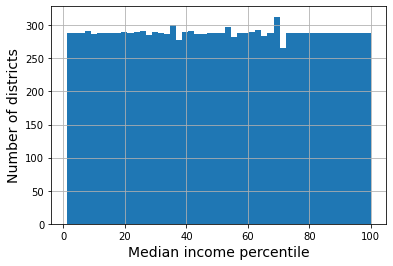

In [159]:
percentiles = [ 
    np.percentile(dataX['median_income'], p)
    for p in range(1, 100)
] # value each percentile

flatten_median_income = pd.cut(dataX['median_income'], bins=[-np.inf] + percentiles + [np.inf], labels=range(1, 101))
flatten_median_income.hist(bins=50)
plt.xlabel('Median income percentile')
plt.ylabel('Number of districts');

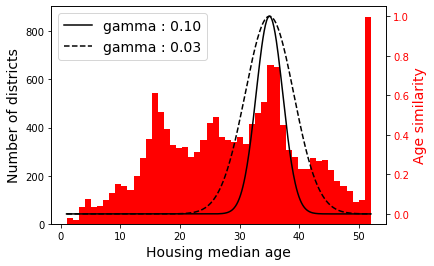

In [160]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(X = dataX[['housing_median_age']], Y = [[35]], gamma=0.1)
ages = np.linspace(dataX['housing_median_age'].min(), dataX['housing_median_age'].max(), 500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fix, ax1 = plt.subplots()
ax1.set_xlabel('Housing median age')
ax1.set_ylabel('Number of districts')
ax1.hist(dataX['housing_median_age'], bins=50, color='red')

ax2 = ax1.twinx() # shares same x-axis
color = 'black'
ax2.plot(ages, rbf1, color=color, label='gamma : 0.10')
ax2.plot(ages, rbf2, color=color, label='gamma : 0.03', linestyle='--')
ax2.tick_params(axis='y', labelcolor='red') # set the number to y-axis
ax2.set_ylabel('Age similarity', color='red')

plt.legend(loc='upper left')
save_fig("rbg_kernel_that_i_don't_get_for_now")

In [161]:
from sklearn.linear_model import LinearRegression

label_scaler = StandardScaler()
scaled_label = label_scaler.fit_transform(dataY.to_numpy().reshape(-1,1))
lin_model = LinearRegression().fit(dataX[['median_income']], scaled_label)

In [162]:
some_new_data = dataX[['median_income']].iloc[:5] # accury not new
scaled_prediction = lin_model.predict(some_new_data)
scaled_prediction

array([[ 0.93150454],
       [-0.54158741],
       [-0.6105945 ],
       [-0.09973237],
       [-0.17333457]])

In [163]:
predict = label_scaler.inverse_transform(scaled_prediction)
predict # to not scaled data

array([[307649.58358784],
       [143451.50154782],
       [135759.63057829],
       [192702.83891231],
       [184498.77560018]])

In [164]:
# can do prediction in one step
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(dataX[['median_income']], dataY)
predict = model.predict(some_new_data)
predict

array([307649.58358784, 143451.50154782, 135759.63057829, 192702.83891231,
       184498.77560018])

Cluster similarlity

In [165]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin) :
    def __init__(self, n_clusters=5, gamma=1.0, random_state=None) :
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None) :
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X) :
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [166]:
cluster_simil = ClusterSimilarity(n_clusters=5, gamma=0.8, random_state=42)
similarities = cluster_simil.fit_transform(dataX[["latitude", "longitude"]], sample_weight=dataY)

In [167]:
similarities[:3].round(2) # similaritires of cluter from 5 cat

array([[0.05, 0.95, 0.  , 0.  , 0.09],
       [0.  , 0.  , 0.64, 0.59, 0.  ],
       [0.  , 0.39, 0.  , 0.  , 0.62]])

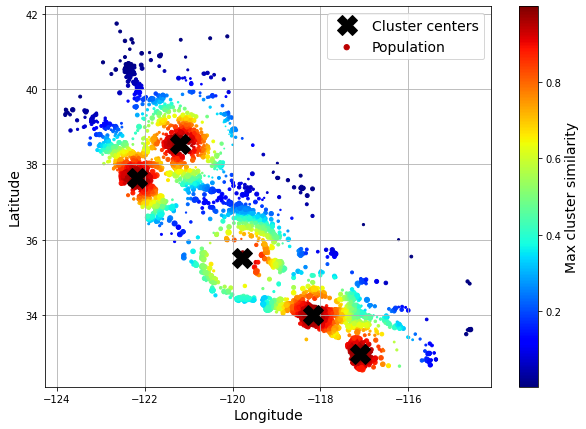

In [168]:
dataX_renamed = dataX.rename(columns={
   "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"
})
dataX_renamed['Max cluster similarity'] = similarities.max(axis=1)
dataX_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude", grid=True,
    s=dataX_renamed["Population"] / 100, label="Population",
    c="Max cluster similarity", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7)
)

plt.plot(
    cluster_simil.kmeans_.cluster_centers_[:, 1],
    cluster_simil.kmeans_.cluster_centers_[:, 0],
    linestyle="", color="black", marker="X", markersize=20,
    label="Cluster centers"
)
plt.legend(loc="upper right")
save_fig("district_cluster_plot")


Transformation Pipelines

In [169]:
from sklearn.pipeline import Pipeline
#numerical attributes
num_pipe = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

housing_num_prepared = num_pipe.fit_transform(numerical_data)
housing_num_prepared[:2]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.36816703,
         0.13746004,  1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43592476,
        -0.69377062, -0.37348471,  1.17194198]])

In [170]:
num_pipe.steps

[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]

In [171]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipe = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocesser = ColumnTransformer([
    ('num', num_pipe, num_attribs),
    ('cat', cat_pipe, cat_attribs)
])

preprocesser

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

In [172]:
# or this is faster
from sklearn.compose import make_column_selector, make_column_transformer

preprocesser = make_column_transformer(
    (num_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, make_column_selector(dtype_include=object))
)
preprocesser

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000141A4651630>),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000141A4650400>)])

In [173]:
housing_prepared = preprocesser.fit_transform(dataX)
housing_prepared[0]

array([ 0.59552705, -0.69280115,  0.87590394, -0.25753938, -0.47934192,
       -0.91142322, -0.36775613,  1.38399016,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [174]:
preprocesser.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [175]:
#flexible transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipe, ['ocean_proximity']),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [181]:
housing_prepared = preprocessing.fit_transform(dataX)
housing_prepared.shape

(14448, 24)

In [183]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

Select and Train a Model

In [191]:
from sklearn.linear_model import LinearRegression

# full pipe and model
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(dataX, dataY)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [211]:
predict = lin_reg.predict(dataX)
predict[:4].round(-2), dataY.iloc[:4].values

(array([379400., 118900.,  96400., 344000.]),
 array([483800., 101700.,  96100., 361800.]))

In [209]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(dataY, predict)
lin_mse

4357694823.3821

In [212]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(dataX, dataY)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(n_clusters=10,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [217]:
predict = tree_reg.predict(dataX)
predict[:5], dataY.iloc[:5].values

(array([483800., 101700.,  96100., 361800.,  92600.]),
 array([483800., 101700.,  96100., 361800.,  92600.]))

In [218]:
tree_mse = mean_squared_error(dataY, predict)
tree_mse

0.0

Better Evaluation Using Cross-Validation

In [222]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, dataX, dataY, scoring='neg_root_mean_squared_error', cv=5)
tree_rmses

array([65630.42154007, 65715.26819348, 64894.6396252 , 62698.44503773,
       66123.78006148])

In [223]:
pd.Series(tree_rmses).describe()

count        5.000000
mean     65012.510892
std       1367.424127
min      62698.445038
25%      64894.639625
50%      65630.421540
75%      65715.268193
max      66123.780061
dtype: float64

In [224]:
lin_rmses = -cross_val_score(lin_reg, dataX, dataY, scoring="neg_root_mean_squared_error", cv=5)
pd.Series(lin_rmses).describe()

count        5.000000
mean     69018.249478
std       4475.696061
min      64691.653764
25%      67108.904099
50%      67296.590455
75%      69595.830556
max      76398.268514
dtype: float64

In [225]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, dataX, dataY, scoring="neg_root_mean_squared_error", cv=5)
pd.Series(forest_rmses).describe()

count        5.000000
mean     46137.837803
std       1017.583041
min      44896.530123
25%      45513.872274
50%      46222.885137
75%      46471.224544
max      47584.676937
dtype: float64

In [227]:
forest_reg.fit(dataX, dataY)
predict = forest_reg.predict(dataX)
forest_rmse = mean_squared_error(dataY, predict, squared=False)
forest_rmse

16933.6322622217

The training error is much lower than the validation error, which usually means that the model has overfit the training set

Fine best parameters : in RandomForest

In [232]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(dataX, dataY)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ocean_proximity'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [235]:
full_pipeline.get_params().keys() # hyperparams can adjust

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__simpleimputer__verbose', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose'

In [236]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [270]:
cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_result = cv_result[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_result.rename(columns={
    'param_preprocessing__geo__n_clusters':'n_clusters',
    'param_random_forest__max_features':'max_features',
    'split0_test_score':'split0', 'split1_test_score':'split1',
    'split2_test_score':'split2','mean_test_score': 'mean_test_rmse'
}, inplace=True)

In [271]:
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_result[score_cols] = -cv_result[score_cols].round().astype(np.int64)
cv_result

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,41957,43245,42192,42464
13,15,8,42374,43584,42632,42863
14,15,10,42672,44125,43065,43287
7,10,6,43024,44676,43705,43802
9,10,6,43024,44676,43705,43802
8,10,8,43490,44382,44033,43968
10,10,8,43490,44382,44033,43968
6,10,4,43492,44938,43719,44049
4,8,6,43683,44846,43916,44148
11,10,10,43845,45133,44398,44459


In [276]:
# Randomized Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_dist = {
    'preprocessing__geo__n_clusters' : randint(low=3, high=50),
    'random_forest__max_features' : randint(low=3, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=params_dist, n_iter=5, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(dataX, dataY)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=5,
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000141A00109D0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000141A0012F20>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [277]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,10,40037,41968,40192,40732
0,41,17,40805,42524,41309,41546
2,23,9,41240,42934,41818,41997
3,21,13,41968,43900,42475,42781
4,13,6,42495,43972,42970,43146


Analye the Best Models and Their Errors

In [291]:
best_model = rnd_search.best_estimator_ # include preprocessing
feature_importances = best_model['random_forest'].feature_importances_

In [296]:
sorted(zip(feature_importances, best_model['preprocessing'].get_feature_names_out()), reverse=True)

[(0.18542519993299886, 'log__median_income'),
 (0.07795279033956601, 'cat__ocean_proximity_INLAND'),
 (0.061110648811815334, 'people_per_house__ratio'),
 (0.05500368993082205, 'rooms_per_house__ratio'),
 (0.05410789073340192, 'bedrooms__ratio'),
 (0.04392394614443165, 'geo__Cluster 30 similarity'),
 (0.034580729584939636, 'geo__Cluster 2 similarity'),
 (0.020176116464416874, 'geo__Cluster 41 similarity'),
 (0.019738564530523615, 'geo__Cluster 23 similarity'),
 (0.019395955470805977, 'geo__Cluster 43 similarity'),
 (0.018411857077961603, 'geo__Cluster 20 similarity'),
 (0.017607575178271974, 'geo__Cluster 36 similarity'),
 (0.015394140649311189, 'geo__Cluster 27 similarity'),
 (0.015160512752422521, 'geo__Cluster 25 similarity'),
 (0.014646210568760967, 'geo__Cluster 0 similarity'),
 (0.014173805091295497, 'geo__Cluster 40 similarity'),
 (0.013125356232747739, 'geo__Cluster 12 similarity'),
 (0.013069301483622965, 'remainder__housing_median_age'),
 (0.012684707972001615, 'geo__Cluster 5

In [303]:
predict = best_model.predict(dataX)
rmse = mean_squared_error(dataY, predict, squared=False)
rmse

14735.626428429556

In [305]:
# compute 95% confidence interval RMSE : T-score
from scipy import stats

confidence = 0.95
squred_errors = (predict-dataY)**2
np.sqrt(stats.t.interval(confidence, len(squred_errors)-1, 
                         loc=squred_errors.mean(), scale=stats.sem(squred_errors)))

array([14318.09674009, 15141.64714349])

In [313]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squred_errors.std(ddof=1) / np.sqrt(len(squred_errors))
np.sqrt(squred_errors.mean() - zmargin), np.sqrt(squred_errors.mean() + zmargin)

(14318.132230519588, 15141.613583294858)

Model persistence using joblib

In [314]:
import joblib

joblib.dump(best_model, "best_model/housing_best_model.pkl")

['best_model/housing_best_model.pkl']

In [315]:
best_model_reloaded = joblib.load("best_model/housing_best_model.pkl")
best_model_reloaded

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000014...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(n_clusters=45,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('random_forest',
                 RandomForestRegressor(max_features=10, random_state=42))])

In [322]:
new_data = dataX.iloc[:5]
predict = best_model_reloaded.predict(new_data)
print(predict.round(-2),'\n',dataY.iloc[:5].values)

[459400. 108500. 102000. 340400. 103900.] 
 [483800. 101700.  96100. 361800.  92600.]
